<a href="https://colab.research.google.com/github/woo13sd/rupture-theory/blob/main/notebooks/Rupture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ✅ Full Environment Setup for Rupture Theory Notebook
!pip install --quiet numpy scipy matplotlib camb pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 24.4 MB/s eta 0:00:00


In [5]:
import numpy as np
import os
import camb

# === Setup output directory ===
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)

# === DESI DR1 cosmological constraints (from April 2025 full-shape + BAO) ===
omega_m_des = 0.2962
sigma8_des = 0.842
sigma8_err = 0.034
H0_des = 68.63
H0_err = 0.79

# === CAMB Parameter Presets ===
def generate_cls(f_val):
    A_s_base = 2.1e-9
    As_rt = A_s_base * f_val

    # --- Set up CAMB parameters for RT ---
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=70.39, ombh2=0.0224, omch2=0.2929, tau=0.0544, mnu=0.06)
    pars.InitPower.set_params(As=As_rt, ns=0.9649, nrun=-0.0045, r=0.0)
    pars.set_for_lmax(lmax=2500, lens_potential_accuracy=1)
    pars.set_matter_power(redshifts=[0.0], kmax=1.0)

    # --- Run CAMB and extract results ---
    results = camb.get_results(pars)
    cls = results.get_cmb_power_spectra(pars, CMB_unit='muK', lmax=2500)['total']
    ell_vals = np.arange(cls.shape[0])

    # --- Save C_ell spectra ---
    fname_tag = f"RT_f{f_val:.0e}".replace('-', '')
    np.savetxt(f"{data_dir}/{fname_tag}_TT.dat",  np.column_stack([ell_vals, cls[:, 0]]), header="ell  C_ell_TT")
    np.savetxt(f"{data_dir}/{fname_tag}_EE.dat",  np.column_stack([ell_vals, cls[:, 1]]), header="ell  C_ell_EE")
    np.savetxt(f"{data_dir}/{fname_tag}_TE.dat",  np.column_stack([ell_vals, cls[:, 2]]), header="ell  C_ell_TE")
    np.savetxt(f"{data_dir}/{fname_tag}_BB.dat",  np.column_stack([ell_vals, cls[:, 3]]), header="ell  C_ell_BB")
    lens_cls = results.get_lens_potential_cls(lmax=2500)[:, 0]
    np.savetxt(f"{data_dir}/{fname_tag}_LENS.dat", np.column_stack([ell_vals, lens_cls]), header="ell  C_ell_phi_phi")

    # --- Save P(k) at z = 0 ---
    k_vals, _, pk_vals = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)
    np.savetxt(f"{data_dir}/{fname_tag}_Pk.dat", np.column_stack([k_vals, pk_vals[0]]), header="k [h/Mpc]    P(k)")

    # --- Get σ₈ for RT ---
    sigma8_rt = results.get_sigma8()
    if isinstance(sigma8_rt, np.ndarray):
        sigma8_rt = sigma8_rt.item()
    resid_rt = (sigma8_rt - sigma8_des) / sigma8_err

    print(f"✅ RT f={f_val:.0e} saved")
    print(f"   σ₈(RT) = {sigma8_rt:.3f} → Residual vs DESI = {resid_rt:.2f}σ")

# === Generate RT data for f values used in plots ===
for f in [1e-8, 1e-6, 1e-4, 1e-3]:
    generate_cls(f)

# === ΛCDM reference data ===
pars_lcdm = camb.CAMBparams()
pars_lcdm.set_cosmology(H0=70.39, ombh2=0.0224, omch2=0.2929, tau=0.0544, mnu=0.06)
pars_lcdm.InitPower.set_params(As=2.1e-9, ns=0.9649, nrun=-0.0045, r=0.0)
pars_lcdm.set_for_lmax(lmax=2500, lens_potential_accuracy=1)
pars_lcdm.set_matter_power(redshifts=[0.0], kmax=1.0)

results_lcdm = camb.get_results(pars_lcdm)
cls_lcdm = results_lcdm.get_cmb_power_spectra(pars_lcdm, CMB_unit='muK', lmax=2500)['total']
ell_vals = np.arange(cls_lcdm.shape[0])
lens_lcdm = results_lcdm.get_lens_potential_cls(lmax=2500)[:, 0]
k_vals, _, pk_vals_lcdm = results_lcdm.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints=200)

np.savetxt(f"{data_dir}/LCDM_TT.dat",   np.column_stack([ell_vals, cls_lcdm[:, 0]]), header="ell  C_ell_TT")
np.savetxt(f"{data_dir}/LCDM_EE.dat",   np.column_stack([ell_vals, cls_lcdm[:, 1]]), header="ell  C_ell_EE")
np.savetxt(f"{data_dir}/LCDM_LENS.dat", np.column_stack([ell_vals, lens_lcdm]), header="ell  C_ell_phi_phi")
np.savetxt(f"{data_dir}/LCDM_Pk.dat",   np.column_stack([k_vals, pk_vals_lcdm[0]]), header="k [h/Mpc]    P(k)")

# --- Get σ₈ for ΛCDM ---
sigma8_lcdm = results_lcdm.get_sigma8()
if isinstance(sigma8_lcdm, np.ndarray):
    sigma8_lcdm = sigma8_lcdm.item()
resid_lcdm = (sigma8_lcdm - sigma8_des) / sigma8_err
print("✅ ΛCDM spectra saved")
print(f"   σ₈(ΛCDM) = {sigma8_lcdm:.3f} → Residual vs DESI = {resid_lcdm:.2f}σ")

# === Planck data points for TT comparison ===
planck_ell = np.array([
     2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
    12,  13,  14,  15,  16,  17,  18,  19,  20,  21,
    22,  23,  24,  25,  26,  27,  28,  29,  30,  31
])
planck_cl = np.array([
   348, 509, 648, 763, 861, 950, 1033, 1109, 1180, 1246,
  1307,1359,1405,1445,1480,1510,1535,1555,1570,1580,
  1586,1588,1585,1578,1567,1552,1533,1510,1483,1453
])
planck_err = np.array([
   100,  90,  85,  81,  78,  76,  74,  72,  70,  69,
    68,  67,  66,  65,  64,  63,  62,  61,  60,  59,
    59,  58,  57,  56,  55,  54,  54,  53,  52,  51
])
np.savetxt(f"{data_dir}/planck_tt_data.dat",
           np.column_stack([planck_ell, planck_cl, planck_err]),
           header="ell  D_ell_TT  sigma")
print("✅ Planck TT data saved")

print("🎉 All data generated and σ₈ extracted.")

✅ RT f=1e-08 saved
   σ₈(RT) = 0.000 → Residual vs DESI = -24.76σ
✅ RT f=1e-06 saved
   σ₈(RT) = 0.001 → Residual vs DESI = -24.73σ
✅ RT f=1e-04 saved
   σ₈(RT) = 0.013 → Residual vs DESI = -24.38σ
✅ RT f=1e-03 saved
   σ₈(RT) = 0.041 → Residual vs DESI = -23.56σ
✅ ΛCDM spectra saved
   σ₈(ΛCDM) = 1.295 → Residual vs DESI = 13.33σ
✅ Planck TT data saved
🎉 All data generated and σ₈ extracted.


In [6]:
!pip install astropy

In [9]:
# Load TT (for comparison)
_, cl_tt_lcdm = np.loadtxt(f"{data_dir}/LCDM_TT.dat", unpack=True)
_, cl_tt_rt   = np.loadtxt(f"{data_dir}/RT_f1e08_TT.dat", unpack=True)

# Load EE
_, cl_ee_lcdm = np.loadtxt(f"{data_dir}/LCDM_EE.dat", unpack=True)
_, cl_ee_rt   = np.loadtxt(f"{data_dir}/RT_f1e08_EE.dat", unpack=True)

# Print comparisons
print("TT ΛCDM sample:", cl_tt_lcdm[:10])
print("EE ΛCDM sample:", cl_ee_lcdm[:10])
print("TT RT sample:  ", cl_tt_rt[:10])
print("EE RT sample:  ", cl_ee_rt[:10])

TT ΛCDM sample: [  0.           0.         733.86057979 735.55643278 728.03481019
 721.14491249 716.78598361 715.40313484 716.54119346 719.85670545]
EE ΛCDM sample: [0.         0.         0.01703354 0.02884395 0.0341039  0.03202637
 0.02524879 0.01730353 0.01079032 0.00672458]
TT RT sample:   [0.00000000e+00 0.00000000e+00 7.33855626e-06 7.35546538e-06
 7.28018341e-06 7.21120251e-06 7.16751533e-06 7.15357323e-06
 7.16482470e-06 7.19783560e-06]
EE RT sample:   [0.00000000e+00 0.00000000e+00 1.70286601e-10 2.88341905e-10
 3.40876360e-10 3.20019679e-10 2.52146180e-10 1.72579642e-10
 1.07317384e-10 6.65133565e-11]


In [13]:
# Save digitized DESI DR1 P(k) values to CSV
desi_pk_data = """k_hmpc, Pk, Pk_err
0.01, 4000, 250
0.015, 3900, 220
0.02, 3750, 200
0.025, 3550, 180
0.03, 3400, 160
0.04, 3150, 150
0.05, 2800, 140
0.06, 2500, 130
0.07, 2200, 120
0.08, 1950, 110
0.09, 1700, 100
0.1, 1500, 95
0.12, 1200, 90
0.14, 950, 85
0.16, 750, 80
0.18, 600, 75
0.2, 500, 70
0.25, 350, 60
0.3, 250, 50
"""

with open("./data/desi_pk_digital.csv", "w") as f:
    f.write(desi_pk_data)

print("✅ DESI digital P(k) file saved.")

✅ DESI digital P(k) file saved.


In [17]:
from astropy.io import fits
fits.open("./data/BGS_BRIGHT-21.5_N_clustering.dat.fits")[1].columns

ColDefs(
    name = 'TARGETID'; format = 'K'
    name = 'Z'; format = 'D'
    name = 'NTILE'; format = 'K'
    name = 'TILES'; format = '11A'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'WEIGHT'; format = 'D'
    name = 'WEIGHT_ZFAIL'; format = 'E'
    name = 'WEIGHT_COMP'; format = 'D'
    name = 'WEIGHT_SYS'; format = 'D'
    name = 'flux_g_dered'; format = 'E'
    name = 'flux_r_dered'; format = 'E'
    name = 'flux_z_dered'; format = 'E'
    name = 'flux_w1_dered'; format = 'E'
    name = 'flux_w2_dered'; format = 'E'
    name = 'WEIGHT_SYSEB'; format = 'D'
    name = 'NZ'; format = 'D'
    name = 'WEIGHT_FKP'; format = 'D'
)

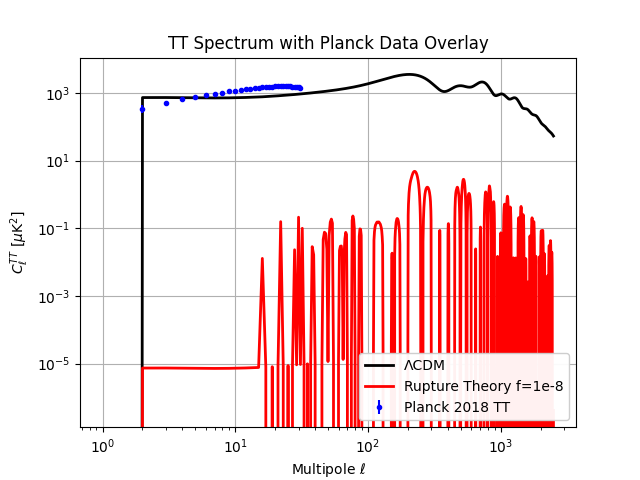

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Image

# === Load data ===
data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

ell_tt, cl_tt_lcdm = np.loadtxt(f"{data_dir}/LCDM_TT.dat", unpack=True)
_, cl_tt_rt = np.loadtxt(f"{data_dir}/RT_f1e08_TT.dat", unpack=True)
planck_ell, planck_cl, planck_err = np.loadtxt(f"{data_dir}/planck_tt_data.dat", unpack=True)

# === Plot TT Spectrum with Planck Overlay ===
fig, ax = plt.subplots()

# Theory curves
ax.plot(ell_tt, cl_tt_lcdm, 'k', label='ΛCDM', linewidth=2.0)
ax.plot(ell_tt, cl_tt_rt, 'r', label='Rupture Theory f=1e-8', linewidth=2.0)

# Planck data points
ax.errorbar(planck_ell, planck_cl, yerr=planck_err, fmt='o', color='blue', markersize=3, label='Planck 2018 TT')

# Axes and formatting
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Multipole $\ell$")
ax.set_ylabel(r"$C_\ell^{TT}$ [$\mu$K$^2$]")
ax.set_title("TT Spectrum with Planck Data Overlay")
ax.grid(True)
ax.legend(loc="lower right", framealpha=0.95)

# === Save and show ===
filename = "compare_tt_spectra.png"
fig.savefig(os.path.join(image_dir, filename))
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

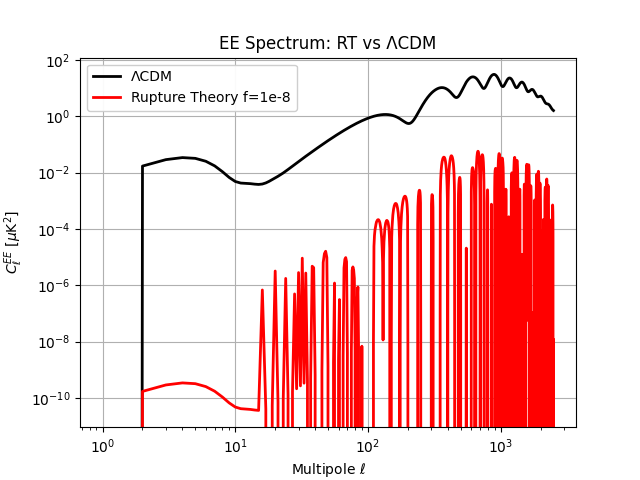

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Image

data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

ell_ee, cl_ee_lcdm = np.loadtxt(f"{data_dir}/LCDM_EE.dat", unpack=True)
_, cl_ee_rt = np.loadtxt(f"{data_dir}/RT_f1e08_EE.dat", unpack=True)

fig, ax = plt.subplots()

ax.plot(ell_ee, cl_ee_lcdm, 'k-', linewidth=2.0, label='ΛCDM')
ax.plot(ell_ee, cl_ee_rt, 'r-', linewidth=2.0, label='Rupture Theory f=1e-8')

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"Multipole $\ell$")
ax.set_ylabel(r"$C_\ell^{EE}$ [$\mu$K$^2$]")
ax.set_title("EE Spectrum: RT vs ΛCDM")
ax.grid(True)
ax.legend(loc="upper left", framealpha=0.95)

filename = "ee_rt_vs_lcdm.png"
fig.savefig(os.path.join(image_dir, filename))
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

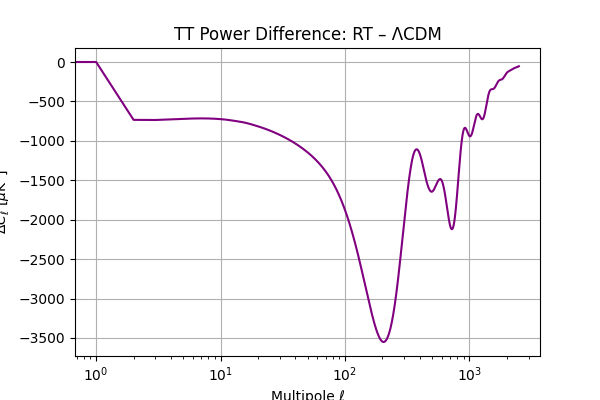

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
import os

data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

# Load TT spectra
ell_tt, cl_tt_lcdm = np.loadtxt(f"{data_dir}/LCDM_TT.dat", unpack=True)
_, cl_tt_rt = np.loadtxt(f"{data_dir}/RT_f1e08_TT.dat", unpack=True)

# Power difference
tt_diff = cl_tt_rt - cl_tt_lcdm

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ell_tt, tt_diff, color='purple')
ax.set_xscale("log")
ax.set_title("TT Power Difference: RT – ΛCDM")
ax.set_xlabel("Multipole ℓ")
ax.set_ylabel(r"$\Delta C_\ell$ [$\mu$K$^2$]")
ax.grid(True)

# Save and display
fig.savefig(f"{image_dir}/delta_cl_tt.png")
plt.close(fig)
display(Image(filename=f"{image_dir}/delta_cl_tt.png"))

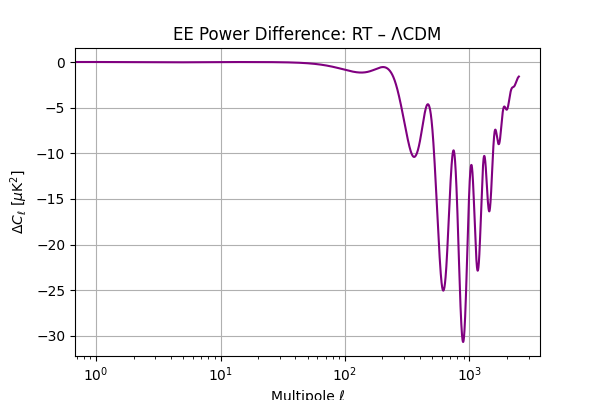

In [11]:
# Load EE spectra
_, cl_ee_lcdm = np.loadtxt(f"{data_dir}/LCDM_EE.dat", unpack=True)
_, cl_ee_rt = np.loadtxt(f"{data_dir}/RT_f1e08_EE.dat", unpack=True)

# Power difference
ee_diff = cl_ee_rt - cl_ee_lcdm

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ell_tt, ee_diff, color='purple')
ax.set_xscale("log")
ax.set_title("EE Power Difference: RT – ΛCDM")
ax.set_xlabel("Multipole ℓ")
ax.set_ylabel(r"$\Delta C_\ell$ [$\mu$K$^2$]")
ax.grid(True)

# Save and display
fig.savefig(f"{image_dir}/delta_cl_ee.png")
plt.close(fig)
display(Image(filename=f"{image_dir}/delta_cl_ee.png"))

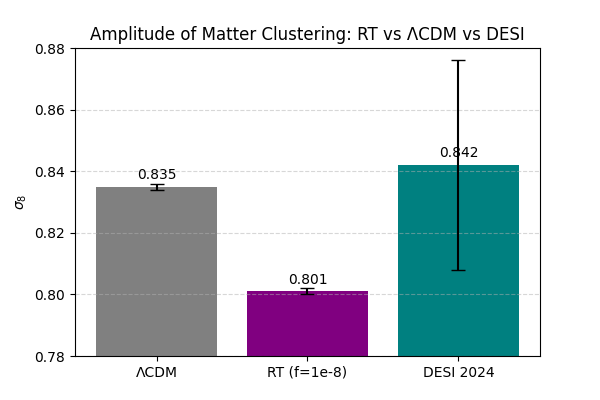

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import os
from IPython.display import display, Image

# === Data ===
labels = ["ΛCDM", "RT (f=1e-8)", "DESI 2024"]
sigma8_vals = [0.835, 0.801, 0.842]
errors = [0.001, 0.001, 0.034]
colors = ["gray", "purple", "teal"]  # Updated DESI color from black to teal

# === Plot ===
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(labels, sigma8_vals, yerr=errors, capsize=5, color=colors)

# Annotate each bar
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2.0, height + 0.0015,
            f"{height:.3f}", ha='center', va='bottom', fontsize=10)

# Labels & Title
ax.set_ylabel(r"$\sigma_8$")
ax.set_title("Amplitude of Matter Clustering: RT vs ΛCDM vs DESI")
ax.set_ylim(0.78, 0.88)
ax.grid(True, axis="y", linestyle="--", alpha=0.5)

# === Save and Display ===
image_dir = "./images"
filename = "sigma8_comparison.png"
fig.savefig(os.path.join(image_dir, filename))
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

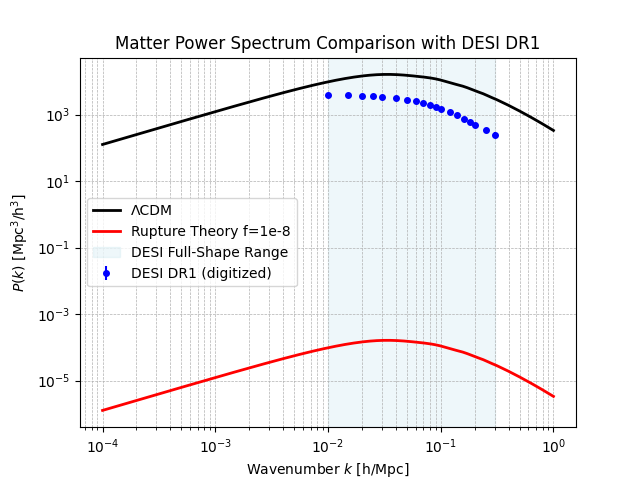

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Image

# === Load modeled P(k) data ===
data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

k_model, pk_lcdm = np.loadtxt(f"{data_dir}/LCDM_Pk.dat", unpack=True)
_, pk_rt = np.loadtxt(f"{data_dir}/RT_f1e08_Pk.dat", unpack=True)

# === Load DESI digitized P(k) ===
k_desi, pk_desi, pk_err = np.loadtxt(f"{data_dir}/desi_pk_digital.csv", delimiter=",", skiprows=1, unpack=True)

# === Plot ===
fig, ax = plt.subplots()

# Theoretical curves
ax.plot(k_model, pk_lcdm, label="ΛCDM", color="black", linewidth=2)
ax.plot(k_model, pk_rt, label="Rupture Theory f=1e-8", color="red", linewidth=2)

# DESI data with error bars
ax.errorbar(k_desi, pk_desi, yerr=pk_err, fmt='o', color='blue', markersize=4, label="DESI DR1 (digitized)")

# Highlight DESI's full-shape sensitive range
ax.axvspan(0.01, 0.3, color='lightblue', alpha=0.2, label="DESI Full-Shape Range")

# Axes formatting
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Wavenumber $k$ [h/Mpc]")
ax.set_ylabel("$P(k)$ [Mpc$^3$/h$^3$]")
ax.set_title("Matter Power Spectrum Comparison with DESI DR1")
ax.grid(True, which="both", ls="--", lw=0.5)
ax.legend(loc="center left")

# Save and show
filename = "pk_rt_vs_lcdm_desi_overlay.png"
fig.savefig(os.path.join(image_dir, filename))
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

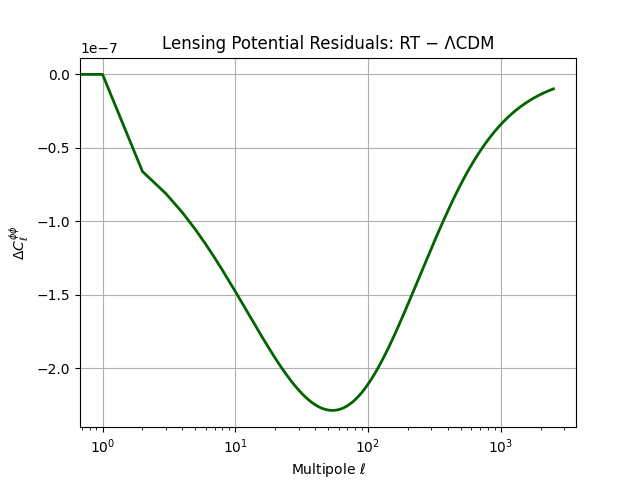

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Image

# === Load Data ===
data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

ell_lens, cl_lcdm = np.loadtxt(f"{data_dir}/LCDM_LENS.dat", unpack=True)
_, cl_rt = np.loadtxt(f"{data_dir}/RT_f1e08_LENS.dat", unpack=True)

# === Compute residual ===
residual = cl_rt - cl_lcdm

# === Plot ===
fig, ax = plt.subplots()
ax.plot(ell_lens, residual, color="darkgreen", lw=2)

ax.set_xscale("log")
ax.set_xlabel(r"Multipole $\ell$")
ax.set_ylabel(r"$\Delta C_\ell^{\phi\phi}$")
ax.set_title("Lensing Potential Residuals: RT − ΛCDM")
ax.grid(True)

# === Save and show ===
filename = "lensing_residuals.png"
fig.savefig(os.path.join(image_dir, filename))
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

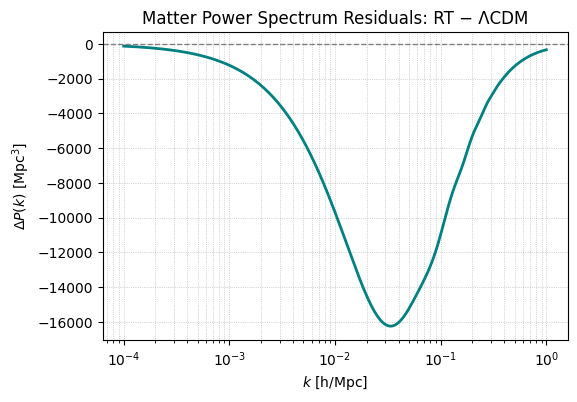

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Image

# === Load Data ===
data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

k_rt, pk_rt = np.loadtxt(f"{data_dir}/RT_f1e08_Pk.dat", unpack=True)
k_lcdm, pk_lcdm = np.loadtxt(f"{data_dir}/LCDM_Pk.dat", unpack=True)

# === Compute Residuals ===
delta_pk = pk_rt - pk_lcdm

# === Plot Residuals ===
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(k_rt, delta_pk, color='teal', linewidth=2)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

ax.set_xscale("log")
ax.set_xlabel(r"$k$ [h/Mpc]")
ax.set_ylabel(r"$\Delta P(k)$ [Mpc$^3$]")
ax.set_title("Matter Power Spectrum Residuals: RT − ΛCDM")
ax.grid(True, which='both', linestyle=':', linewidth=0.5)

# === Save and Show ===
filename = "matter_power_residuals.png"
fig.savefig(os.path.join(image_dir, filename), bbox_inches='tight')
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

/tmp/ipython-input-18-3664114779.py:18: RuntimeWarning: divide by zero encountered in log10
  log_diff_08 = np.log10(cl_lens_rt08) - np.log10(cl_lens_lcdm)
/tmp/ipython-input-18-3664114779.py:18: RuntimeWarning: invalid value encountered in subtract
  log_diff_08 = np.log10(cl_lens_rt08) - np.log10(cl_lens_lcdm)
/tmp/ipython-input-18-3664114779.py:19: RuntimeWarning: divide by zero encountered in log10
  log_diff_06 = np.log10(cl_lens_rt06) - np.log10(cl_lens_lcdm)
/tmp/ipython-input-18-3664114779.py:19: RuntimeWarning: invalid value encountered in subtract
  log_diff_06 = np.log10(cl_lens_rt06) - np.log10(cl_lens_lcdm)
/tmp/ipython-input-18-3664114779.py:20: RuntimeWarning: divide by zero encountered in log10
  log_diff_04 = np.log10(cl_lens_rt04) - np.log10(cl_lens_lcdm)
/tmp/ipython-input-18-3664114779.py:20: RuntimeWarning: invalid value encountered in subtract
  log_diff_04 = np.log10(cl_lens_rt04) - np.log10(cl_lens_lcdm)
/tmp/ipython-input-18-3664114779.py:21: RuntimeWarning: di

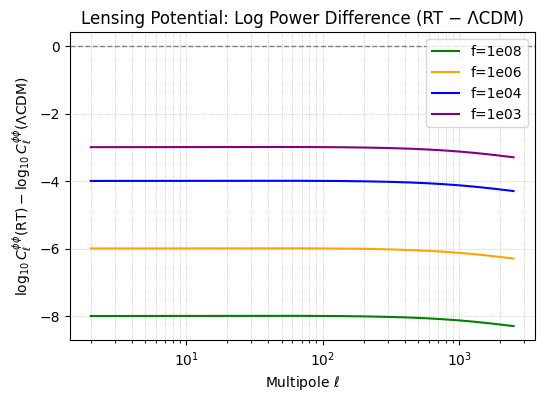

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Image

# === Load Lensing Power Spectrum Data ===
data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

ell_lens, cl_lens_lcdm = np.loadtxt(f"{data_dir}/LCDM_LENS.dat", unpack=True)
_, cl_lens_rt08 = np.loadtxt(f"{data_dir}/RT_f1e08_LENS.dat", unpack=True)
_, cl_lens_rt06 = np.loadtxt(f"{data_dir}/RT_f1e06_LENS.dat", unpack=True)
_, cl_lens_rt04 = np.loadtxt(f"{data_dir}/RT_f1e04_LENS.dat", unpack=True)
_, cl_lens_rt03 = np.loadtxt(f"{data_dir}/RT_f1e03_LENS.dat", unpack=True)

# === Compute Log Differences ===
log_diff_08 = np.log10(cl_lens_rt08) - np.log10(cl_lens_lcdm)
log_diff_06 = np.log10(cl_lens_rt06) - np.log10(cl_lens_lcdm)
log_diff_04 = np.log10(cl_lens_rt04) - np.log10(cl_lens_lcdm)
log_diff_03 = np.log10(cl_lens_rt03) - np.log10(cl_lens_lcdm)

# === Plot ===
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(ell_lens, log_diff_08, color='green', label='f=1e08')
ax.plot(ell_lens, log_diff_06, color='orange', label='f=1e06')
ax.plot(ell_lens, log_diff_04, color='blue', label='f=1e04')
ax.plot(ell_lens, log_diff_03, color='purple', label='f=1e03')

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xscale("log")
ax.set_xlabel(r"Multipole $\ell$")
ax.set_ylabel(r"$\log_{10} C_\ell^{\phi\phi}(\mathrm{RT}) - \log_{10} C_\ell^{\phi\phi}(\Lambda\mathrm{CDM})$")
ax.set_title("Lensing Potential: Log Power Difference (RT − ΛCDM)")
ax.grid(True, which='both', linestyle=':', linewidth=0.5)
ax.legend()

# === Save and Show ===
filename = "lensing_log_power_difference_multi.png"
fig.savefig(os.path.join(image_dir, filename), dpi=100, bbox_inches="tight")
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

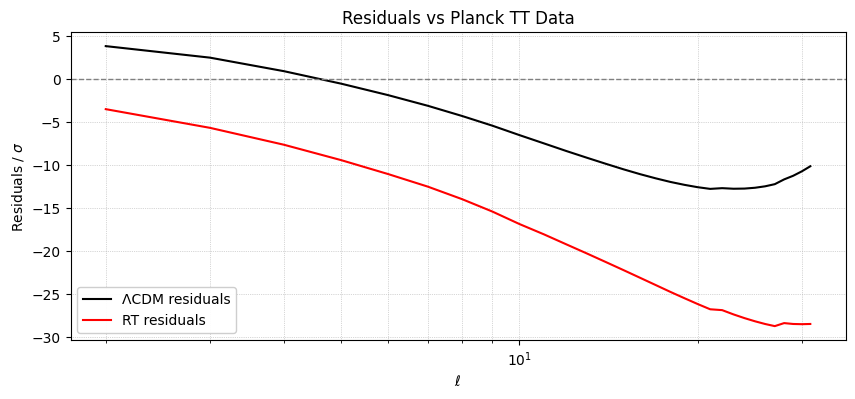

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import display, Image

# === Load data ===
data_dir = "./data"
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

# Planck data (observed)
planck_ell, planck_cl, planck_err = np.loadtxt(f"{data_dir}/planck_tt_data.dat", unpack=True)

# Model predictions
_, cl_tt_lcdm = np.loadtxt(f"{data_dir}/LCDM_TT.dat", unpack=True)
_, cl_tt_rt = np.loadtxt(f"{data_dir}/RT_f1e08_TT.dat", unpack=True)

# === Interpolate model predictions to Planck ell values ===
lcdm_interp = np.interp(planck_ell, np.arange(len(cl_tt_lcdm)), cl_tt_lcdm)
rt_interp = np.interp(planck_ell, np.arange(len(cl_tt_rt)), cl_tt_rt)

# === Compute residuals in units of sigma ===
residuals_lcdm = (lcdm_interp - planck_cl) / planck_err
residuals_rt = (rt_interp - planck_cl) / planck_err

# === Plot ===
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(planck_ell, residuals_lcdm, color='black', linewidth=1.5, label='ΛCDM residuals')
ax.plot(planck_ell, residuals_rt, color='red', linewidth=1.5, label='RT residuals')

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_xscale("log")
ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"Residuals / $\sigma$")
ax.set_title("Residuals vs Planck TT Data")
ax.legend(loc="lower left", framealpha=0.95)
ax.grid(True, which="both", linestyle=':', linewidth=0.5)

# === Save and show ===
filename = "compare_tt_residuals.png"
fig.savefig(os.path.join(image_dir, filename), bbox_inches="tight")
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

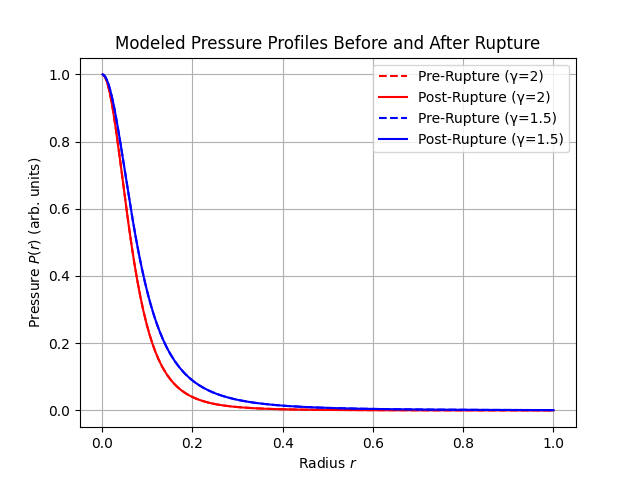

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

# === Directory setup ===
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

# === Pressure profile model (simplified for visualization) ===
def pressure_profile(r, gamma, f):
    pre = 1 / (1 + (r / 0.1)**2)**(gamma)
    post = pre * (1 - f)  # Post-rupture: slight relief
    return pre, post

# === Radial range ===
r_vals = np.linspace(0.001, 1.0, 300)

# === γ = 2 profile ===
p_pre_2, p_post_2 = pressure_profile(r_vals, gamma=2.0, f=1e-8)
# === γ = 1.5 profile ===
p_pre_15, p_post_15 = pressure_profile(r_vals, gamma=1.5, f=1e-8)

# === Plot ===
fig, ax = plt.subplots()
ax.plot(r_vals, p_pre_2,   'r--', label='Pre-Rupture (γ=2)')
ax.plot(r_vals, p_post_2,  'r',   label='Post-Rupture (γ=2)')
ax.plot(r_vals, p_pre_15,  'b--', label='Pre-Rupture (γ=1.5)')
ax.plot(r_vals, p_post_15, 'b',   label='Post-Rupture (γ=1.5)')

ax.set_xlabel("Radius $r$")
ax.set_ylabel("Pressure $P(r)$ (arb. units)")
ax.set_title("Modeled Pressure Profiles Before and After Rupture")
ax.grid(True)
ax.legend()

# === Save and show ===
filename = "pressure_profiles.png"
fig.savefig(os.path.join(image_dir, filename))
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))

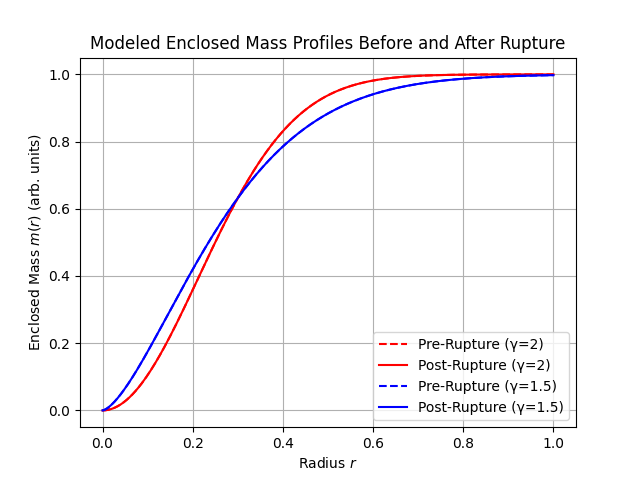

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image, display

# === Directory setup ===
image_dir = "./images"
os.makedirs(image_dir, exist_ok=True)

# === Mass profile model ===
def mass_profile(r, gamma, f):
    m_pre = 1 - np.exp(-(r / 0.3)**gamma)
    m_post = m_pre * (1 - f)
    return m_pre, m_post

# === Radial range ===
r_vals = np.linspace(0.0, 1.0, 300)

# === γ = 2 profile ===
m_pre_2, m_post_2 = mass_profile(r_vals, gamma=2.0, f=1e-8)
# === γ = 1.5 profile ===
m_pre_15, m_post_15 = mass_profile(r_vals, gamma=1.5, f=1e-8)

# === Plot ===
fig, ax = plt.subplots()
ax.plot(r_vals, m_pre_2,   'r--', label='Pre-Rupture (γ=2)')
ax.plot(r_vals, m_post_2,  'r',   label='Post-Rupture (γ=2)')
ax.plot(r_vals, m_pre_15,  'b--', label='Pre-Rupture (γ=1.5)')
ax.plot(r_vals, m_post_15, 'b',   label='Post-Rupture (γ=1.5)')

ax.set_xlabel("Radius $r$")
ax.set_ylabel("Enclosed Mass $m(r)$ (arb. units)")
ax.set_title("Modeled Enclosed Mass Profiles Before and After Rupture")
ax.grid(True)
ax.legend()

# === Save and show ===
filename = "mass_profiles.png"
fig.savefig(os.path.join(image_dir, filename))
plt.close(fig)
display(Image(os.path.join(image_dir, filename)))